In [1]:
!pip install pytorch-wavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

In [2]:
import torch
import math

def cosine_beta_schedule(timesteps, s=0.008):
    """
    Cosine schedule as proposed in Nichol & Dhariwal 2021
    https://arxiv.org/abs/2102.09672

    timesteps: number of diffusion steps
    s: small constant for numerical stability
    returns: beta schedule tensor of shape [timesteps]
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]

    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clamp(betas, 0.0001, 0.999)

In [3]:
import torch
import torch.nn as nn
from pytorch_wavelets import DWTForward, DWTInverse

# ------------------------ Wavelet Block ------------------------ #
class WaveletBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt = DWTForward(J=1, mode='zero', wave='haar')
        self.conv = nn.Conv2d(9, 64, kernel_size=1) 
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        yl, yh = self.dwt(x) 
        yh = yh[0]  # first level
        yh = yh.reshape(yh.shape[0], -1, yh.shape[-2], yh.shape[-1]) 

        # Upsample high-frequency to match input
        yh_upsampled = nn.functional.interpolate(yh, size=x.shape[-2:], mode='bilinear', align_corners=False)

        features = self.relu(self.conv(yh_upsampled))
        return features

# ------------------------ Residual Block ------------------------ #
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return self.relu(out)

# ------------------------ Generator ------------------------ #
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_features=64):
        super().__init__()
        self.wavelet     = WaveletBlock()
        self.conv1       = nn.Conv2d(in_channels, num_features, 3, padding=1)
        self.res_blocks  = nn.Sequential(*[ResBlock(num_features) for _ in range(8)])
        
        # first upsample + sharpen
        self.upconv1     = nn.ConvTranspose2d(num_features, num_features, 4, stride=2, padding=1)
        self.res_up1     = ResBlock(num_features)
        
        # second upsample + sharpen
        self.upconv2     = nn.ConvTranspose2d(num_features, num_features, 4, stride=2, padding=1)
        self.res_up2     = ResBlock(num_features)
        
        # RGB
        self.conv_final  = nn.Conv2d(num_features, in_channels, 3, padding=1)
        self.tanh        = nn.Tanh()

    def forward(self, x):
        # 1) initial conv + wavelet
        feat          = self.conv1(x)
        wavelet_feats = self.wavelet(x)
        out           = feat + wavelet_feats
        
        # 2) deep residual blocks
        out = self.res_blocks(out)
        
        # 3) upsample + sharpening
        out = self.upconv1(out)
        out = self.res_up1(out)
        
        # 4) upsample + sharpening
        out = self.upconv2(out)
        out = self.res_up2(out)
        
        # 5) to RGB
        out = self.conv_final(out)
        return out



# ------------------------ Discriminator ------------------------ #
import torch
import torch.nn as nn
from torch.nn.utils import spectral_norm

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, base_features=64):
        super().__init__()
        def sn_conv(in_f, out_f, k, s, p):
            # SpectralNorm + Conv + LeakyReLU
            return nn.Sequential(
                spectral_norm(nn.Conv2d(in_f, out_f, kernel_size=k, stride=s, padding=p)),
                nn.LeakyReLU(0.2, inplace=True)
            )

        # 70×70 PatchGAN:
        self.model = nn.Sequential(
            # input: N×3×H×W → N×64×H/2×W/2
            *sn_conv(in_channels,   base_features,    4, 2, 1),
            # N×64→128, H/2→H/4
            *sn_conv(base_features, base_features*2,  4, 2, 1),
            # N×128→256, H/4→H/8
            *sn_conv(base_features*2, base_features*4,4, 2, 1),
            # N×256→512, H/8→H/16 (stride=1 to keep patch size ~70)
            *sn_conv(base_features*4, base_features*8,4, 1, 1),
            # Final conv to 1-channel “realness” map
            spectral_norm(nn.Conv2d(base_features*8, 1, kernel_size=4, stride=1, padding=1))
        )

    def forward(self, x):
        return self.model(x)


# ------------------------ UNet Denoiser ------------------------ #
# --- Timestep Embedding --- #
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -(math.log(10000) / (half_dim)))
        emb = t[:, None].float() * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)


# --- Self-Attention Block --- #
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.key   = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.value = nn.Conv2d(in_dim, in_dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.shape
        q = self.query(x).view(B, -1, H*W).permute(0, 2, 1)
        k = self.key(x).view(B, -1, H*W)                    
        attn = torch.bmm(q, k) / (C ** 0.5)                
        attn = torch.softmax(attn, dim=-1)

        v = self.value(x).view(B, -1, H*W)             
        out = torch.bmm(v, attn.permute(0, 2, 1)).view(B, C, H, W)
        return self.gamma * out + x


# --- UNet Block with Time Embedding --- #
class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=None):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
        if time_emb_dim:
            self.time_proj = nn.Sequential(
                nn.Linear(time_emb_dim, out_ch),
                nn.ReLU(inplace=True)
            )
        else:
            self.time_proj = None

    def forward(self, x, t_emb=None):
        out = self.conv(x)
        if self.time_proj is not None and t_emb is not None:
            B, C, H, W = out.shape
            time_feat = self.time_proj(t_emb).view(B, C, 1, 1)
            out = out + time_feat
        return out


# --- Full UNet Denoiser --- #
class UNetDenoiser(nn.Module):
    def __init__(self, in_channels=3, base=64, time_emb_dim=128):
        super().__init__()
        self.time_embed = SinusoidalTimeEmbedding(time_emb_dim)

        self.enc1 = UNetBlock(in_channels, base, time_emb_dim)
        self.enc2 = UNetBlock(base, base*2, time_emb_dim)
        self.enc3 = UNetBlock(base*2, base*4, time_emb_dim)
        self.enc4 = UNetBlock(base*4, base*8, time_emb_dim)

        self.pool = nn.MaxPool2d(2)

        self.middle = UNetBlock(base*8, base*8, time_emb_dim)
        self.attention =  SelfAttention(base*8)

        self.up4 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.dec4 = UNetBlock(base*12, base*4, time_emb_dim)

        self.up3 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec3 = UNetBlock(base*6, base*2, time_emb_dim)

        self.up2 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec2 = UNetBlock(base*3, base, time_emb_dim)

        self.up1 = nn.ConvTranspose2d(base, base, 2, stride=2)
        self.dec1 = UNetBlock(base*2, base, time_emb_dim)

        self.outc = nn.Conv2d(base, in_channels, 1)

    def forward(self, x, t):
        t_emb = self.time_embed(t)

        e1 = self.enc1(x, t_emb)
        e2 = self.enc2(self.pool(e1), t_emb)
        e3 = self.enc3(self.pool(e2), t_emb)
        e4 = self.enc4(self.pool(e3), t_emb)

        m = self.middle(self.pool(e4), t_emb)
        m = self.attention(m)

        d4 = self.up4(m)
        d4 = self.dec4(torch.cat([d4, e4], dim=1), t_emb)

        d3 = self.up3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1), t_emb)

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1), t_emb)

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1), t_emb)

        return self.outc(d1)

# ------------------------ Diffusion Generator ------------------------ #
class DiffusionGenerator(nn.Module):
    def __init__(self, in_channels=3, timesteps=100):
        super().__init__()
        self.timesteps = timesteps
        self.denoiser = UNetDenoiser(in_channels)
        self.register_buffer("betas", cosine_beta_schedule(timesteps))  # device-safe

    def forward(self, x):
        noise = torch.randn_like(x)
        beta = self.betas[-1].to(x.device)
        x_noisy = x + beta * noise
        for t in reversed(range(25)):
            t_tensor = torch.tensor([t] * x.size(0), device=x.device)
            x_noisy = self.denoiser(x_noisy, t_tensor)
        return x_noisy

# ------------------------ Combined Generator ------------------------ #
class CombinedGenerator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.diffusion = DiffusionGenerator(in_channels)
        self.gan = Generator(in_channels)

    def forward(self, x):
        x_diff = self.diffusion(x)
        gen_hr = self.gan(x)
        return gen_hr , x_diff 

In [4]:
import torch
from torchsummary import summary 

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = CombinedGenerator().to(device)

# Dummy input - adjust size based on your expected LR image size
dummy_input = torch.randn(1, 3, 64, 64).to(device)

# Forward pass
with torch.no_grad():
    output , x_diff = model(dummy_input)

# Print input and output shapes
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")

# Optional: summary of model
# summary(model, input_size=(3, 128, 128))


Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 3, 256, 256])


In [5]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import random

class DIV2KDataset(Dataset):
    def __init__(self, root_dir="/kaggle/input/div2k-dataset/", train=True, scale_factor=2):
        """
        Args:
            root_dir (str): Directory with DIV2K dataset
            train (bool): If True, creates dataset from training set, otherwise from validation set
            scale_factor (int): Scale factor for super-resolution (default: 4x upscaling)
        """
        self.root_dir = root_dir
        self.train = train
        self.scale_factor = scale_factor
        
        # Get list of image files
        self.image_files = self._get_image_files()
        
        # Define transforms for LR images
        self.lr_transform = transforms.Compose([
            transforms.Resize(size=(128 // self.scale_factor, 128 // self.scale_factor), 
                           interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])

    def _get_image_files(self):
        """Get list of image files from DIV2K dataset"""
        if self.train:
            image_dir = os.path.join(self.root_dir, "DIV2K_train_HR")
        else:
            image_dir = os.path.join(self.root_dir, "DIV2K_valid_HR")
            
        files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        files.sort()  # Ensure consistent ordering
        
        if self.train:
            return files[:800]  # First 800 images for training
        return files  # All validation images

    def __len__(self):
        """Return the total number of images in the dataset"""
        return len(self.image_files)

    def __getitem__(self, idx):
        """Return a dictionary containing both LR and HR images"""
        img_name = self.image_files[idx]
        
        # Load HR image
        if self.train:
            img_path = os.path.join(self.root_dir, "DIV2K_train_HR", img_name)
        else:
            img_path = os.path.join(self.root_dir, "DIV2K_valid_HR", img_name)
            
        hr_image = Image.open(img_path).convert('RGB')
        
        # Random crop for training
        if self.train:
            # Random crop to fixed size for HR
            hr_cropped = transforms.RandomCrop(128 * self.scale_factor)(hr_image)
            # Create LR version
            lr_image = self.lr_transform(hr_cropped)
            # Convert HR to tensor
            hr_tensor = transforms.ToTensor()(hr_cropped)
            # hr_tensor = hr_tensor * 2 - 1
        else:
            # For validation, use center crop
            hr_cropped = transforms.CenterCrop(128 * self.scale_factor)(hr_image)
            lr_image = self.lr_transform(hr_cropped)
            hr_tensor = transforms.ToTensor()(hr_cropped)

        return {
            'lr': lr_image,  # Low resolution image
            'hr': hr_tensor  # High resolution image
        }

# Example usage:
if __name__ == "__main__":
    # Create dataset instance
    dataset = DIV2KDataset(root_dir="/kaggle/input/div2k_train_hr/", train=True)
    print(f"Dataset size: {len(dataset)}")
    
    # Get a sample
    sample = dataset[0]
    print(f"LR image shape: {sample['lr'].shape}")
    print(f"HR image shape: {sample['hr'].shape}")


Dataset size: 800
LR image shape: torch.Size([3, 64, 64])
HR image shape: torch.Size([3, 256, 256])


In [6]:
import torchvision.models as models
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import pytorch_wavelets
import kornia
from pytorch_wavelets import DWTForward
import kornia.losses
import kornia.filters
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


class PerceptualLoss(nn.Module):
    def __init__(self, layers=[3, 8, 15, 22]):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES).features
        self.selected_layers = layers
        self.vgg = vgg.eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        loss = 0
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            y = layer(y)
            if i in self.selected_layers:
                loss += F.l1_loss(x, y)
        return loss

# Edge Loss
def edge_loss(pred, target):
    pred_edges = kornia.filters.sobel(pred)
    target_edges = kornia.filters.sobel(target)
    return nn.L1Loss()(pred_edges, target_edges)

# Wavelet Loss
class WaveletLoss(nn.Module):
    def __init__(self):
        super(WaveletLoss, self).__init__()
        self.dwt = DWTForward(J=1, mode='zero', wave='haar')

    def forward(self, pred, target):
        yl_pred, yh_pred = self.dwt(pred)
        yl_target, yh_target = self.dwt(target)

        loss_l = nn.L1Loss()(yl_pred, yl_target)
        loss_h = nn.L1Loss()(yh_pred[0], yh_target[0])
        return loss_l + loss_h

def tv_loss(img):
    return torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + \
           torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))

def color_loss(fake, real):
    mean_fake = fake.mean(dim=[2,3]) 
    mean_real = real.mean(dim=[2,3])
    return nn.functional.l1_loss(mean_fake, mean_real)


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import torchmetrics

def train(epochs=5, batch_size=8, lr=0.0002, b1=0.5, b2=0.999):
    os.makedirs("results", exist_ok=True)
    os.makedirs("saved_models", exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Create Models and Wrap with DataParallel ---
    generator = CombinedGenerator().to(device)
    discriminator = Discriminator().to(device)

    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        generator = nn.DataParallel(generator)
        discriminator = nn.DataParallel(discriminator)
    else:
        print("Using single GPU or CPU")

    # --- Losses and Optimizers ---
    criterion_GAN = nn.BCEWithLogitsLoss()
    criterion_content = nn.L1Loss()
    criterion_diffusion = nn.MSELoss()
    criterion_perceptual = PerceptualLoss().to(device)
    criterion_edge = edge_loss
    criterion_wavelet = WaveletLoss().to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

    # --- Metrics ---
    psnr_metric = torchmetrics.PeakSignalNoiseRatio().to(device)
    ssim_metric = torchmetrics.StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    dataset = DIV2KDataset(root_dir="/kaggle/input/div2k_train_hr/", train=True)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    generator_losses = []
    discriminator_losses = []
    psnr_scores = []
    ssim_scores = []

    for epoch in range(epochs):
        g_loss_epoch = 0
        d_loss_epoch = 0
        psnr_epoch = 0
        ssim_epoch = 0
        image_shown = False

        for i, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
            lr_imgs = batch['lr'].to(device)
            hr_imgs = batch['hr'].to(device)
            downsampled_hr_imgs = F.interpolate(hr_imgs, size=(64, 64), mode='bilinear', align_corners=False)

            valid = torch.empty((lr_imgs.size(0), 1, 30, 30), device=device)
            fake = torch.empty((lr_imgs.size(0), 1, 30, 30), device=device)

            # --- Train Generator ---
            optimizer_G.zero_grad()
            gen_hr , x_diff = generator(lr_imgs)
            pred_fake = discriminator(gen_hr)

            gen_hr = gen_hr.clamp(0, 1)
            x_diff = x_diff.clamp(0,1)

            # Generator Loss
            loss_GAN = criterion_GAN(pred_fake, valid)
            loss_content = criterion_content(gen_hr, hr_imgs)
            loss_diff = criterion_diffusion(x_diff, downsampled_hr_imgs)
            loss_perceptual = criterion_perceptual(gen_hr, hr_imgs)
            loss_edge = criterion_edge(gen_hr, hr_imgs)
            loss_wavelet = criterion_wavelet(gen_hr, hr_imgs)
            loss_tv = tv_loss(gen_hr)
            loss_color = color_loss(gen_hr, hr_imgs)

            loss_G = (
                0.8 * loss_content +
                5e-3 * loss_GAN +
                0.01 * loss_diff +
                0.06 * loss_perceptual +
                0.05 * loss_edge +
                0.05 * loss_wavelet +
                0.001 * loss_tv +
                0.01 * loss_color  
            )

            loss_G.backward()
            optimizer_G.step()

            # --- Train Discriminator ---
            optimizer_D.zero_grad()
            pred_real = discriminator(hr_imgs)
            loss_real = criterion_GAN(pred_real, valid)

            pred_fake = discriminator(gen_hr.detach())
            loss_fake = criterion_GAN(pred_fake, fake)

            loss_D = (loss_real + loss_fake) / 2
            loss_D.backward()
            optimizer_D.step()

            g_loss_epoch += loss_G.item()
            d_loss_epoch += loss_D.item()

            # --- Calculate Metrics ---
            with torch.no_grad():
                gen_hr_clamped = gen_hr.clamp(0, 1)
                hr_imgs_clamped = hr_imgs.clamp(0, 1)

                psnr_score = psnr_metric(gen_hr_clamped, hr_imgs_clamped)
                ssim_score = ssim_metric(gen_hr_clamped, hr_imgs_clamped)

                psnr_epoch += psnr_score.item()
                ssim_epoch += ssim_score.item()

        # Visualize Generated Images (first batch only)
        if not image_shown:
            num_images = min(gen_hr.size(0), 4)
            gen_images = gen_hr[:num_images].detach().cpu()
            real_images = hr_imgs[:num_images].detach().cpu()

            fig, axes = plt.subplots(2, num_images, figsize=(12, 6))
            for idx in range(num_images):
                axes[0, idx].imshow(gen_images[idx].permute(1, 2, 0).clamp(0, 1))
                axes[0, idx].set_title("Generated")
                axes[0, idx].axis("off")

                axes[1, idx].imshow(real_images[idx].permute(1, 2, 0).clamp(0, 1))
                axes[1, idx].set_title("Real")
                axes[1, idx].axis("off")

            plt.suptitle(f"Epoch {epoch+1}")
            plt.tight_layout()
            plt.show()
            image_shown = True

        # Save Average Loss and Metrics for Epoch
        avg_g_loss = g_loss_epoch / len(dataloader)
        avg_d_loss = d_loss_epoch / len(dataloader)
        avg_psnr = psnr_epoch / len(dataloader)
        avg_ssim = ssim_epoch / len(dataloader)

        generator_losses.append(avg_g_loss)
        discriminator_losses.append(avg_d_loss)
        psnr_scores.append(avg_psnr)
        ssim_scores.append(avg_ssim)

        print(f"[Epoch {epoch+1}/{epochs}] Generator Loss: {avg_g_loss:.4f}, Discriminator Loss: {avg_d_loss:.4f}")
        print(f"[Epoch {epoch+1}/{epochs}] PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")

        # Save model checkpoints
        if (epoch + 1) % 50 == 0:
            torch.save(generator.module.state_dict(), f"saved_models/generator_epoch_{epoch+1}.pth")
            torch.save(discriminator.module.state_dict(), f"saved_models/discriminator_epoch_{epoch+1}.pth")

        torch.cuda.empty_cache()

    # --- Plot Losses ---
    plt.figure(figsize=(10, 6))
    plt.plot(generator_losses, label="Generator Loss", color='blue')
    plt.plot(discriminator_losses, label="Discriminator Loss", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Losses Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("results/loss_plot.png")
    plt.show()

    # --- Plot PSNR and SSIM ---
    plt.figure(figsize=(10, 6))
    plt.plot(psnr_scores, label="PSNR", color='green')
    plt.plot(ssim_scores, label="SSIM", color='purple')
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("Image Quality Metrics Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("results/metrics_plot.png")
    plt.show()


Using 2 GPUs


Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:02<00:00, 191MB/s] 
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
Epoch 1/200:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/utils/spectral_norm.py:103: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attemptin

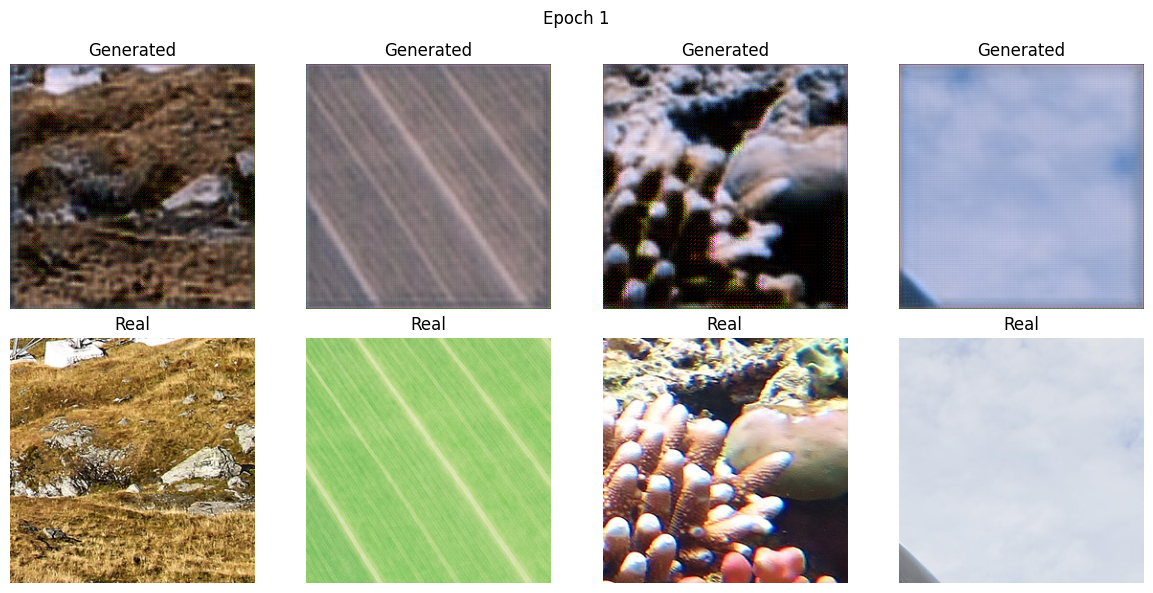

[Epoch 1/200] Generator Loss: 0.3736, Discriminator Loss: 0.6706
[Epoch 1/200] PSNR: 14.46, SSIM: 0.3375


Epoch 2/200: 100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


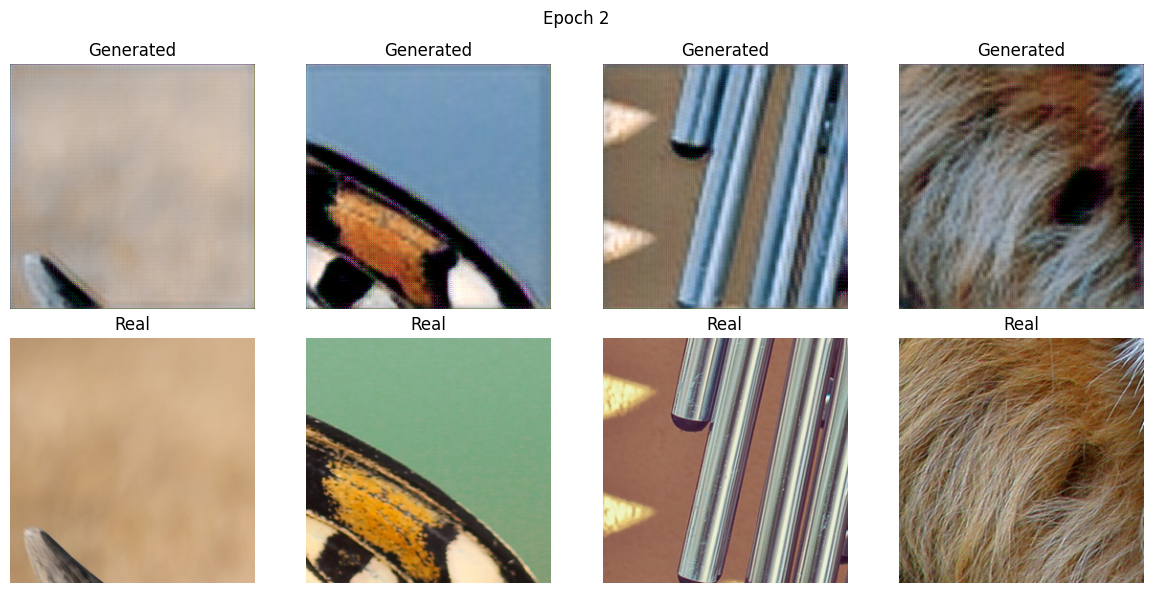

[Epoch 2/200] Generator Loss: 0.2862, Discriminator Loss: 0.6693
[Epoch 2/200] PSNR: 17.09, SSIM: 0.5059


Epoch 3/200: 100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


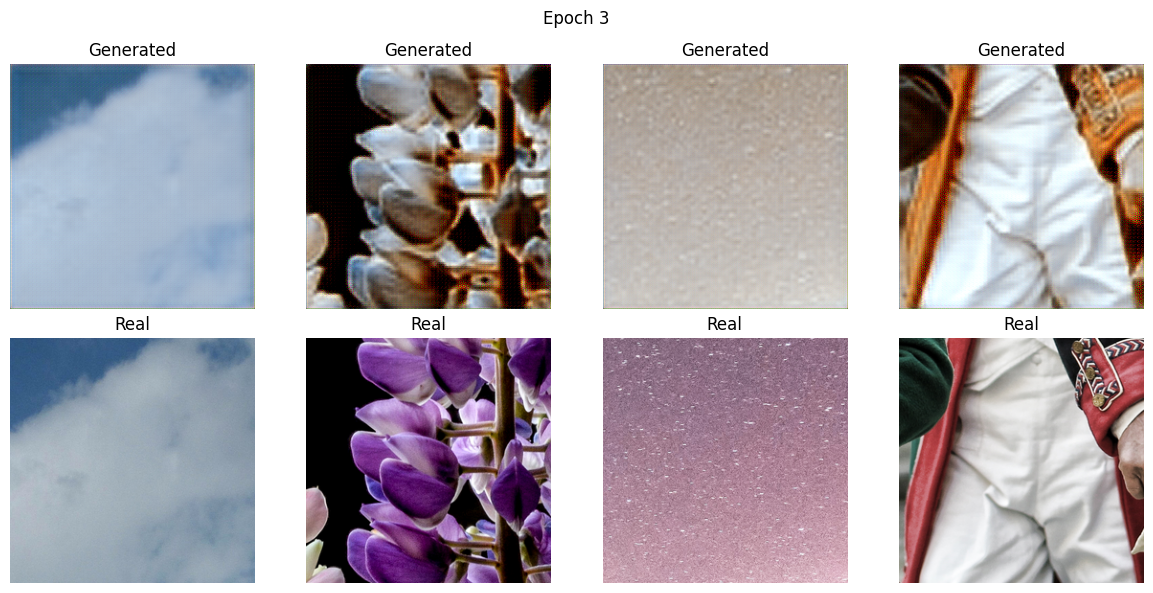

[Epoch 3/200] Generator Loss: 0.2538, Discriminator Loss: 0.6758
[Epoch 3/200] PSNR: 18.40, SSIM: 0.5539


Epoch 4/200:  31%|███       | 31/100 [00:35<01:19,  1.15s/it]


KeyboardInterrupt: 

In [8]:
torch.cuda.empty_cache()
train(epochs=200, batch_size=8)

In [ ]:
torch.cuda.empty_cache()